<a href="https://colab.research.google.com/github/R0n4ldErnest0/sales_store_analysis_t7/blob/main/Store_Sales_Analysis_SQL_GG7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




##Una tienda online de moda, con presencia en todo Brasil, necesita impulsar su rendimiento utilizando sus datos de manera estratégica. Como científico de datos, has sido convocado para analizar estos datos y ofrecer insights que guíen sus decisiones y respondan a las siguientes preguntas clave:

### **Preguntas**

1. ¿Cual es el Top 5 productos más vendidos históricamente?

2. ¿Cual es la evolución histórica de las ingresos netos?

3. ¿Cuáles son los ingresos netos por vendedor por año?

4. ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?

5. ¿Existe otro insight que puedas proporcionar?

#**1. Configuración del Ambiente**


---




In [ ]:
!pip install geobr
import geobr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import requests
from io import BytesIO
from sqlalchemy import create_engine, MetaData, Table, inspect, text
global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database

#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




##**2.1 Cargando las bases de datos**

In [ ]:
df_itens_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/itens_pedidos.csv')
df_itens_pedidos.head()

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0
3,4,3820,1652,6,139,834,BR-DF,166.8
4,5,29012,2470,3,525,1575,BR-BA,315.0


In [ ]:
df_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/pedidos.csv')
df_pedidos.head()

,pedido_id,producto_id,vendedor_id,fecha_compra,total
0,341,41518,6,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575


In [ ]:
df_productos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/productos.csv')
df_productos.head()

,producto_id,producto,precio,marca,sku,condicion
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297.0,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612.0,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482.0,Usado
3,47475,Calca Alfaiataria Preta,490,Mixed,263658.0,Usado
4,74864,Vestido Jeans Babados,130,Zara,219248.0,Usado


In [ ]:
df_vendedores = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/vendedores.csv')
df_vendedores.head(100)

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca
5,6,Unknown


##**2.2 Tratamiento de Datos**

In [ ]:
print(df_itens_pedidos.info())
print('-------------')
print(df_pedidos.info())
print('-------------')
print(df_productos.info())
print('-------------')
print(df_vendedores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pedido_id     24527 non-null  int64 
 1   producto_id   24527 non-null  int64 
 2   vendedor_id   24527 non-null  int64 
 3   fecha_compra  24527 non-null  object
 

In [ ]:
# llaves primarias : pedido_id, producto_id,  vendedor_id
#@ Preprocesamiento
def preprocesamiento():
  global df_itens_pedidos, df_pedidos, df_productos, df_vendedores
  # De acuerdo al .info sabemos que el campo sku y producto tienes dos valores nulos por lo que se procede a eliminar estas 2 filas
  df_productos.dropna(subset=['sku', 'producto'], inplace=True)
  # Eliminamos duplicados en cada DataFrame
  df_itens_pedidos.drop_duplicates(inplace=True)
  df_pedidos.drop_duplicates(inplace=True)
  df_productos.drop_duplicates(inplace=True)
  df_vendedores.drop_duplicates(inplace=True)

  # Elinamos los duplicados en la columna 'pedido_id' del DataFrame df_itens_pedidos y df_pedidos, ya que vienen hacer nuestra codigo clave llave primaria.
  df_itens_pedidos.drop_duplicates(subset=['pedido_id'], inplace=True)
  df_pedidos.drop_duplicates(subset=['pedido_id'], inplace=True)
  # De acuerdo al .info se observa que solo fecha_compra esta como fecha, se procede a convertirlo en formato fecha
  df_pedidos['fecha_compra'] = pd.to_datetime(df_pedidos['fecha_compra'])

  return df_itens_pedidos,df_pedidos,df_productos,df_vendedores

df_itens_pedidos,df_pedidos,df_productos,df_vendedores=preprocesamiento()

In [ ]:
preprocesamiento()
print(df_itens_pedidos.info())
print('-------------')
print(df_pedidos.info())
print('-------------')
print(df_productos.info())
print('-------------')
print(df_vendedores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24527 non-null  int64         
 1   producto_id   24527 non-null  int64         
 2   vendedor_id   24527 non-null  int64         
 3 

##**2.3 Análisis Exploratorio (EDA)**

In [ ]:
df_pedidos.describe()

,pedido_id,producto_id,vendedor_id,fecha_compra,total
count,24527.000000,24527.000000,24527.000000,24527,24527.000000
mean,69931.383088,44627.641171,2.975782,2020-04-02 12:10:46.406001664,1867.490113
min,1.000000,2706.000000,1.000000,2019-01-05 00:00:00,45.000000
25%,34487.000000,17258.000000,2.000000,2019-11-12 00:00:00,520.000000
50%,69945.000000,42913.000000,3.000000,2020-04-09 00:00:00,1050.000000
75%,105355.000000,70673.000000,4.000000,2020-09-21 00:00:00,1920.000000
max,139993.000000,100983.000000,6.000000,2021-03-10 00:00:00,39000.000000
std,40560.769565,29347.824879,1.442412,NaN,3379.681887


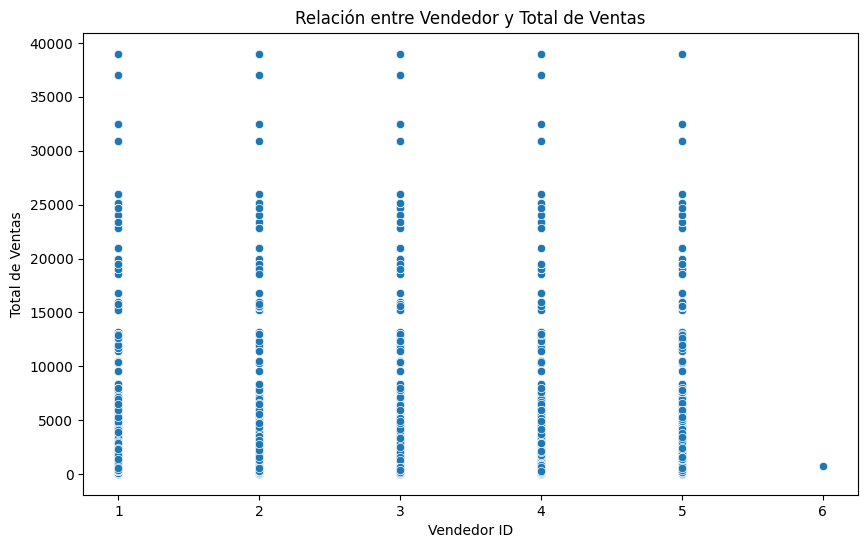

In [ ]:
# Gráfico de dispersión entre vendedor y total de ventas
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vendedor_id', y='total', data=df_pedidos)
plt.title('Relación entre Vendedor y Total de Ventas')
plt.xlabel('Vendedor ID')
plt.ylabel('Total de Ventas')
plt.show()


### Observamos que solo hay una venta en el vendedor 6 por lo que se procede a revisar. De acuerdo a la tabla de vendedores el id_6 tiene como nombre desconocido. Para nuestro estudio eliminaremos porque puede haber sido un suario de prueba, o algun vendedor que ingreso a la empresa y se fue enseguida.

In [ ]:
cantidad_seis = (df_pedidos['vendedor_id'] == 6).sum()
valor_venta_vendedor_6 = df_pedidos[df_pedidos['vendedor_id'] == 6]['total'].sum()
print("Número de veces con el valor 6 en la columna 'vendedor_id':", cantidad_seis)
print("Valor de venta del vendedor con ID 6:", valor_venta_vendedor_6)

Número de veces con el valor 6 en la columna 'vendedor_id': 1
Valor de venta del vendedor con ID 6: 780


In [ ]:
df_pedidos.drop(df_pedidos[df_pedidos['vendedor_id'] == 6].index, inplace=True)

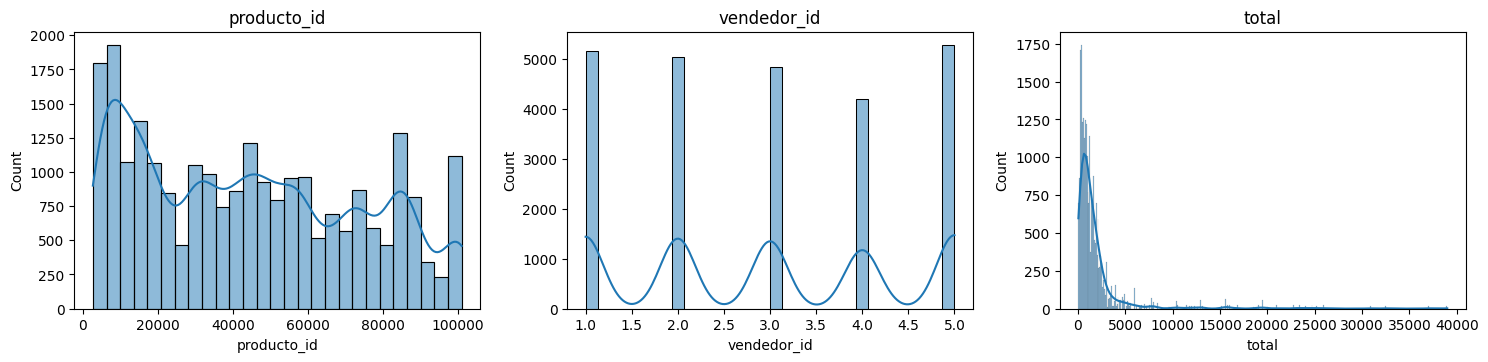

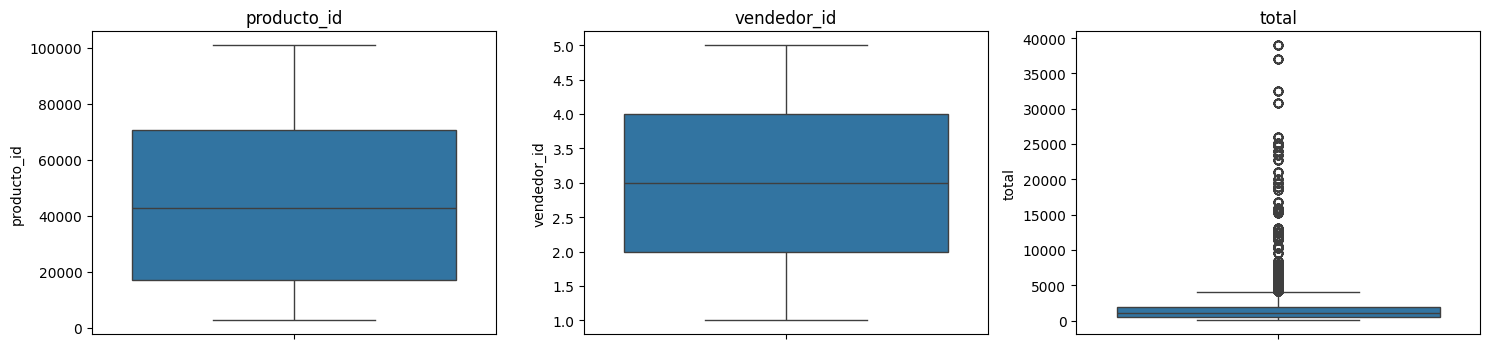

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Histogramas
plt.figure(figsize=(15, 10))
for i, column in enumerate(['producto_id','vendedor_id', 'total']):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_pedidos[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

# boxplots
plt.figure(figsize=(15, 10))
for i, column in enumerate(['producto_id','vendedor_id', 'total']):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df_pedidos[column])
    plt.title(column)
plt.tight_layout()
plt.show()

**Productos más populares:**

En general, hay una variedad de productos, pero algunos tienen más demanda que otros. La mayoría de los productos se venden en cantidades similares, pero hay algunos que son más populares y se venden en cantidades mucho mayores.

**Vendedores destacados:**

Las ventas provienen de cinco vendedores diferentes, y en general, todos parecen estar haciendo un buen trabajo. Sin embargo, el vendedor número 5 parece tener un poco más de actividad que los demás, lo que podría indicar una mayor efectividad en las ventas o una clientela más grande. Pero esto solo es una hipótesis ya que no se lo mismo cantidad de ventas que el valor de las ventas.

**Rango de precios de ventas:**

La mayoría de las ventas que realiza tienen precios más bajos, lo que es bastante común. Sin embargo, ocasionalmente se realizan ventas de mayor valor que sobresalen. Estas ventas más altas podrían representar transacciones especiales o compras de productos de mayor costo.


In [ ]:
df_productos.describe()

,producto_id,precio,sku
count,205.000000,205.000000,205.000000
mean,44803.365854,536.009756,304625.234146
std,29419.632374,843.774387,190141.444036
min,2706.000000,45.000000,101494.000000
25%,17329.000000,210.000000,222028.000000
50%,43054.000000,336.000000,263899.000000
75%,70673.000000,450.000000,304828.000000
max,100983.000000,6500.000000,952821.000000


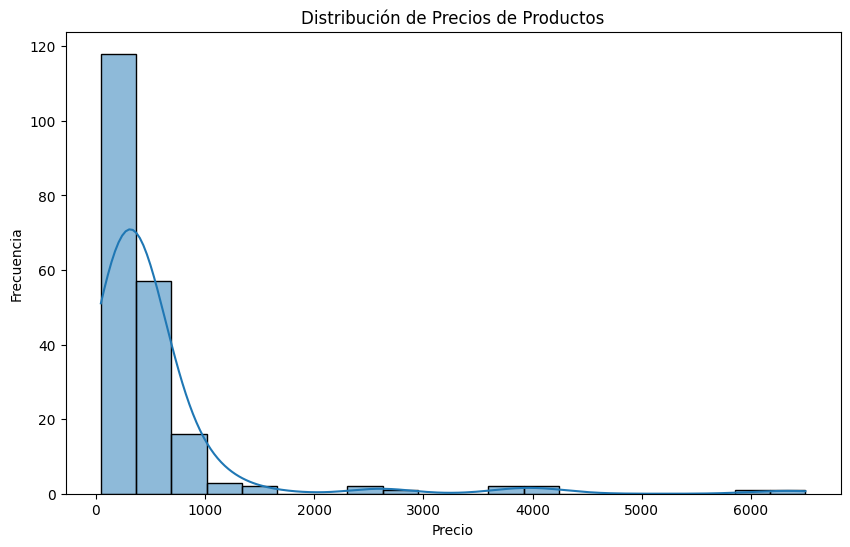

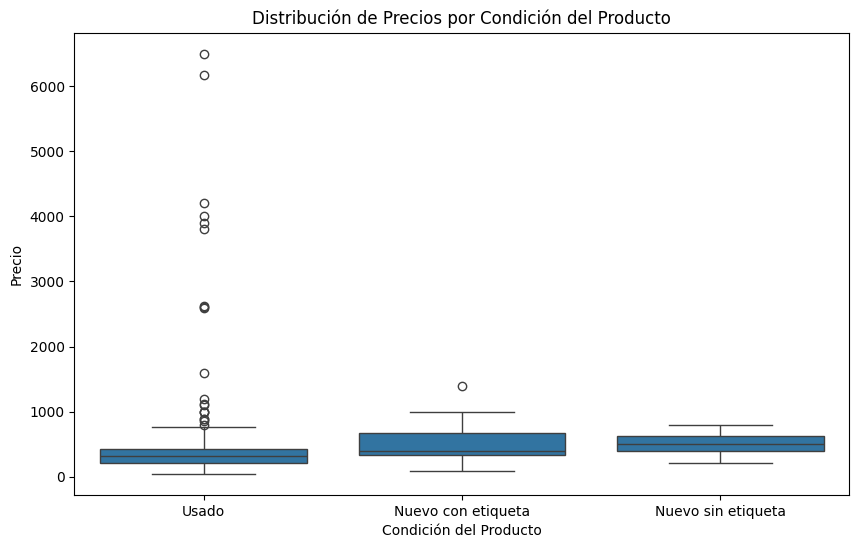

In [ ]:
# Histograma de precios
plt.figure(figsize=(10, 6))
sns.histplot(df_productos['precio'], bins=20, kde=True)
plt.title('Distribución de Precios de Productos')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

# precios por condición del producto
plt.figure(figsize=(10, 6))
sns.boxplot(x='condicion', y='precio', data=df_productos)
plt.title('Distribución de Precios por Condición del Producto')
plt.xlabel('Condición del Producto')
plt.ylabel('Precio')
plt.show()

    Distribución de Precios de Productos (Histograma):

    La mayoría de los productos tienen precios concentrados en el rango más bajo, entre 0 y 1000 unidades monetarias, con una alta frecuencia de aparición.
    A medida que los precios aumentan, la cantidad de productos disponibles disminuye, lo que sugiere que hay menos productos disponibles a precios más altos.
    La distribución muestra una cola larga hacia la derecha, indicando la presencia de algunos productos con precios considerablemente más altos que la mayoría.
         
    Distribución de Precios por Condición del Producto (Diagrama de Caja):

    Los productos nuevos con etiqueta tienden a tener precios más altos en comparación con los productos usados y nuevos sin etiqueta.
    Los productos usados y nuevos sin etiqueta tienen rangos de precios similares, pero los productos usados tienen una mediana ligeramente más baja.
    Se observan valores atípicos en todas las categorías de condición del producto, especialmente en productos nuevos con etiqueta, lo que indica la presencia de algunos productos con precios significativamente más altos dentro de esta categoría.

<ipython-input-18-f60cdd6c8ce9>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


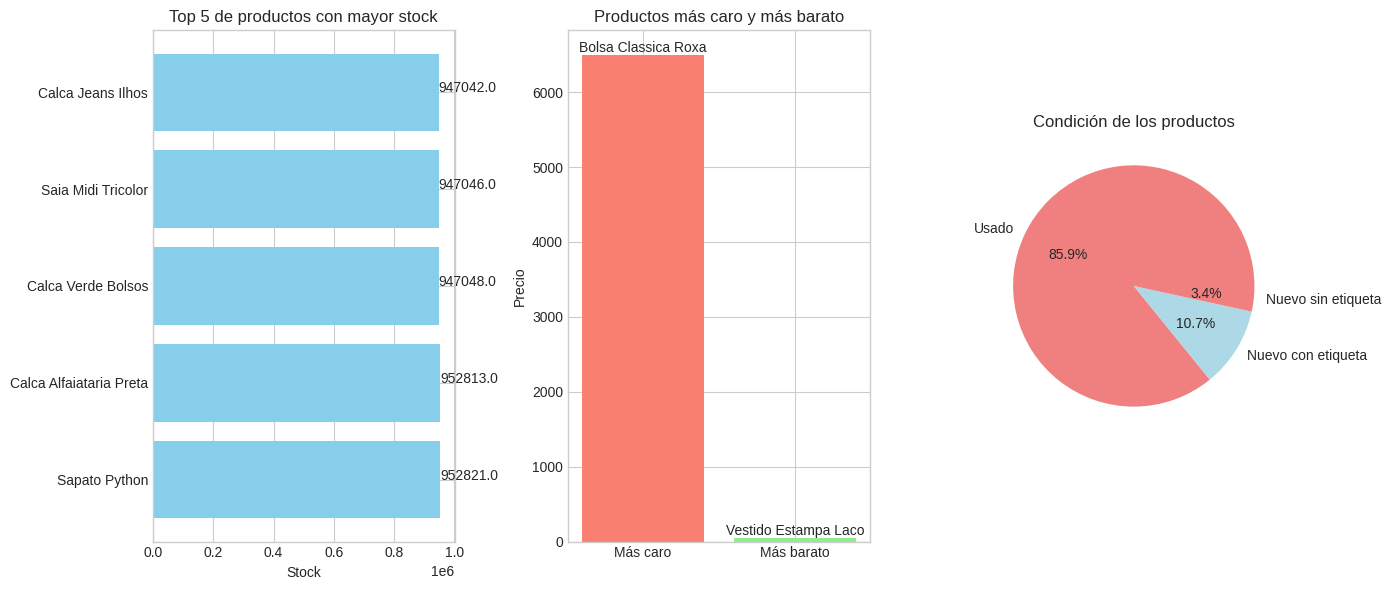

In [ ]:
#top 5 de productos con mayor stock
top_5_stock = df_productos.nlargest(5, 'sku')

# producto más caro y el más barato
producto_mas_caro = df_productos.loc[df_productos['precio'].idxmax()]
producto_mas_barato = df_productos.loc[df_productos['precio'].idxmin()]

# condición de la mayoría de los productos
condicion_mayoria = df_productos['condicion'].mode()[0]
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(14, 6))

#top 5 de productos con mayor stock
plt.subplot(1, 3, 1)
plt.barh(top_5_stock['producto'], top_5_stock['sku'], color='skyblue')
plt.xlabel('Stock')
plt.title('Top 5 de productos con mayor stock')

for index, value in enumerate(top_5_stock['sku']):
    plt.text(value, index, str(value))

#producto más caro y más barato
plt.subplot(1, 3, 2)
plt.bar(['Más caro', 'Más barato'], [producto_mas_caro['precio'], producto_mas_barato['precio']], color=['salmon', 'lightgreen'])
plt.ylabel('Precio')
plt.title('Productos más caro y más barato')
plt.text(0, producto_mas_caro['precio'], producto_mas_caro['producto'], ha='center', va='bottom')
plt.text(1, producto_mas_barato['precio'], producto_mas_barato['producto'], ha='center', va='bottom')

# condición de los productos
plt.subplot(1, 3, 3)
condicion_counts = df_productos['condicion'].value_counts()
plt.pie(condicion_counts, labels=condicion_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Condición de los productos')

plt.tight_layout()
plt.show()

In [ ]:
df_itens_pedidos.describe()

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,costo_envio
count,24527.000000,24527.000000,24527.000000,24527.000000,24527.00000,24527.000000,24527.000000
mean,12405.414278,44627.641171,69931.383088,3.497126,535.68867,1867.490113,373.498023
std,7242.697484,29347.824879,40560.769565,1.706170,839.21405,3379.681887,675.936377
min,1.000000,2706.000000,1.000000,1.000000,45.00000,45.000000,9.000000
25%,6132.500000,17258.000000,34487.000000,2.000000,210.00000,520.000000,104.000000
50%,12264.000000,42913.000000,69945.000000,4.000000,336.00000,1050.000000,210.000000
75%,18689.500000,70673.000000,105355.000000,5.000000,450.00000,1920.000000,384.000000
max,25055.000000,100983.000000,139993.000000,6.000000,6500.00000,39000.000000,7800.000000


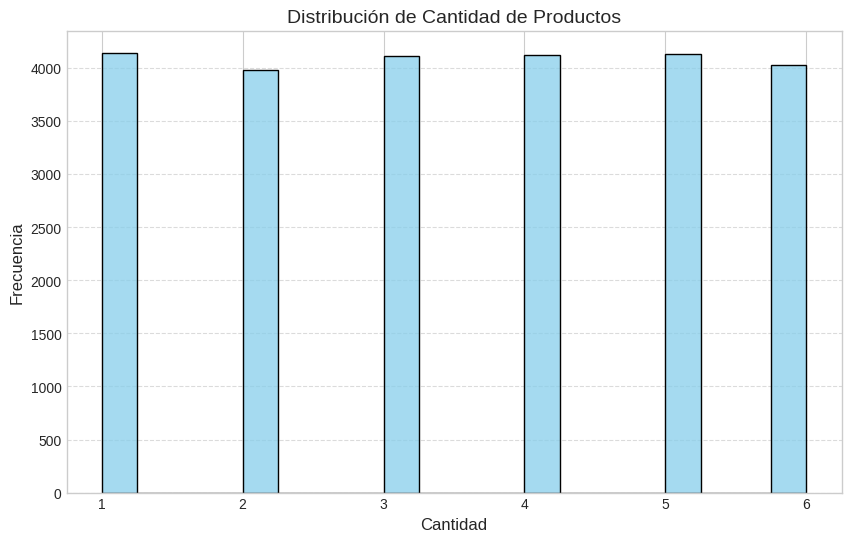

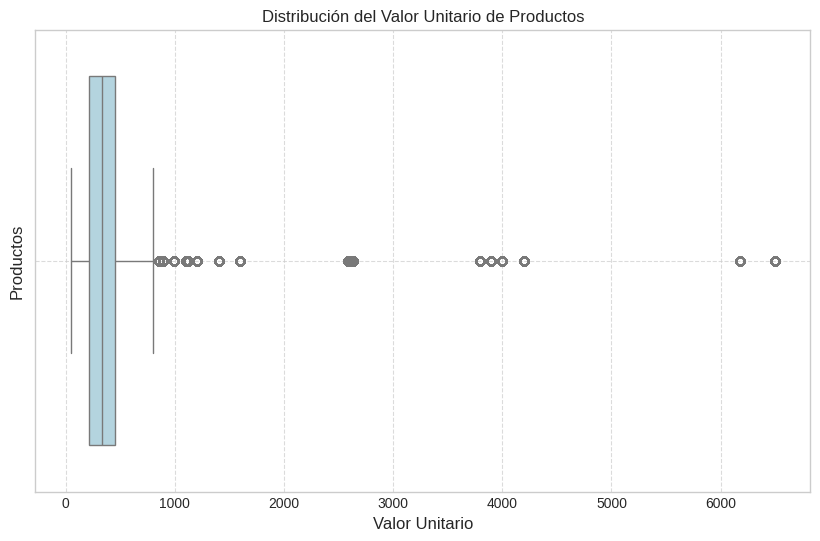

<ipython-input-20-8a7ba9481bd9>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ciudad', data=df_itens_pedidos, order=df_itens_pedidos['ciudad'].value_counts().index, palette='pastel')


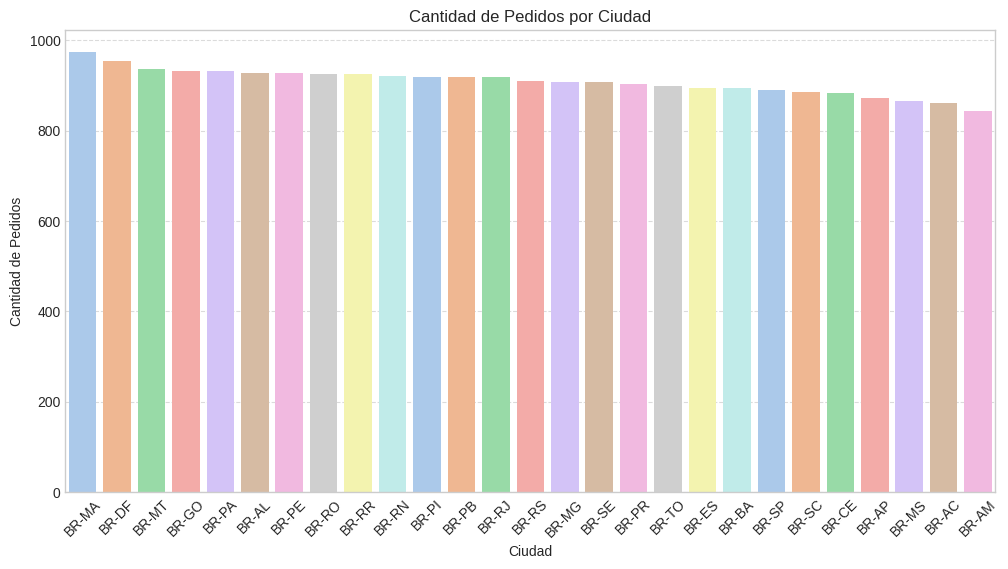

In [ ]:
# Histograma de la cantidad de productos
plt.figure(figsize=(10, 6))
sns.histplot(df_itens_pedidos['cantidad'], bins=20, kde=False, color='skyblue', edgecolor='black')
plt.title('Distribución de Cantidad de Productos', fontsize=14)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Diagrama de caja del valor unitario (horizontal)
plt.figure(figsize=(10, 6))
sns.boxplot(x='valor_unitario', data=df_itens_pedidos, color='lightblue', orient='h')
plt.title('Distribución del Valor Unitario de Productos')
plt.xlabel('Valor Unitario')
plt.ylabel('Productos')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Valor Unitario', fontsize=12)
plt.ylabel('Productos', fontsize=12)
plt.show()

# Gráfico de barras de la cantidad de pedidos por ciudad
plt.figure(figsize=(12, 6))
sns.countplot(x='ciudad', data=df_itens_pedidos, order=df_itens_pedidos['ciudad'].value_counts().index, palette='pastel')
plt.title('Cantidad de Pedidos por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Cantidad de Pedidos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


La mayoria de las ventas se realizan con 1, o de 4 a 5  productos por pedidos. Lo que nos puede llevar a pedirle al cliente que si lleva alguna otra prenda se realizara  un descuento.
La mayoria de los productos tienen valores de precio menor a los 1000, con ciertos productos que tienen costos mas elevados.
La ciudad donde más se envian pedidos es BR-MA


#**3. Preguntas y respuestas**


---




##**3.1 Creando el banco de datos**

In [ ]:
#@title
def crear_conexion():
  global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database
  # Mediante create_engine se crea el motor
  # 'sqlite:///:memory:'  -->
  database = create_engine('sqlite:///:memory:')
  # Usando to_sql se convierte el dataframe en una tabla de SQL
  # 'itens_pedidos'   --> Nombre de la tabla en SQL
  # database          --> Motor donde estará la tabla
  # index=False       --> No se incluye la columna index del dataframe
  df_itens_pedidos.to_sql('itens_pedidos', database, index=False)
  df_pedidos.to_sql('pedidos', database, index=False)
  df_productos.to_sql('productos', database, index=False)
  df_vendedores.to_sql('vendedores', database, index=False)
  return database

In [ ]:
crear_conexion()
inspector = inspect(database)
print('Tablas: ', inspector.get_table_names(), '\n')
print('Columnas de Tabla Pedidos:')
for column in inspector.get_columns('pedidos'):
    print(column)
database.dispose()

Tablas:  ['itens_pedidos', 'pedidos', 'productos', 'vendedores'] 

Columnas de Tabla Pedidos:
{'name': 'producto_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'producto', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'precio', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'marca', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'sku', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'condicion', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}


##**Pregunta 1: ¿Cual es el Top 5 productos más vendidos históricamente?**

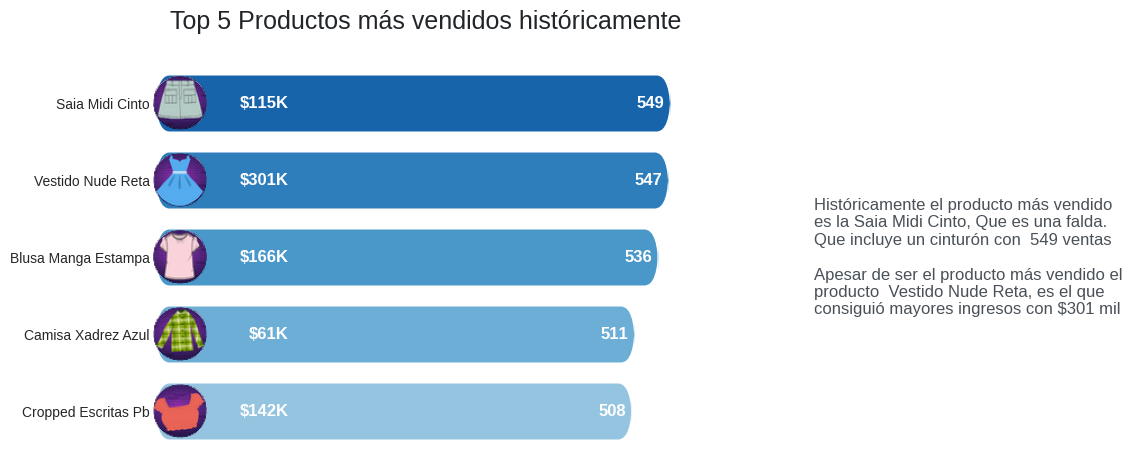

In [ ]:
# Conectar a la base de datos
crear_conexion()
# Consulta SQL para obtener los productos más vendidos
query = """
SELECT ip.producto_id, p.producto, p.marca, SUM(ip.valor_total) AS total_vendido, SUM(ip.cantidad) AS cantidad_vendida
FROM itens_pedidos ip
INNER JOIN productos p ON p.producto_id = ip.producto_id
GROUP BY ip.producto_id, p.producto, p.marca
ORDER BY cantidad_vendida DESC
LIMIT 5
"""
# Leer los datos de la base de datos
df_productos = pd.read_sql(sql=text(query), con=database.connect())
# Cerrar la conexión a la base de datos
database.dispose()

# Convertir el total_vendido a formato de miles con el símbolo de dólar
df_productos['total_vendido'] = (df_productos['total_vendido'] / 1000).apply(lambda x: f'${x:.0f}K')

# Rutas de las imágenes para cada producto
image_paths = [
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/falda.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/vestido.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/blusa.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/camisa.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/cropped.png'
]

# Crear el gráfico de barras horizontales con Seaborn y Matplotlib
plt.subplots(figsize=(7, 5))
colores_azules = plt.cm.Blues_r(np.linspace(0.2, 0.6, len(df_productos)))
ax = sns.barplot(x=df_productos.cantidad_vendida / 20, y=df_productos.producto, orient='h', joinstyle='bevel')

# Lista para almacenar los nuevos parches
new_patches = []

# Iterar sobre cada parche, color, producto, cantidad vendida, total vendido e imagen
for patch, color, producto, cantidad_vendida, total_vendido, image_path in zip(ax.patches, colores_azules, df_productos['producto'], df_productos['cantidad_vendida'], df_productos['total_vendido'], image_paths):
    # Obtener el bounding box del parche
    bb = patch.get_bbox()
    # Crear un nuevo parche
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.05,rounding_size=0.73",
                            ec="none", fc=color,
                            mutation_aspect=0.73
                            )
    # Eliminar el parche original
    patch.remove()
    # Agregar el nuevo parche a la lista
    new_patches.append(p_bbox)

    # Descargar la imagen desde la URL
    response = requests.get(image_path)
    image = plt.imread(BytesIO(response.content))
    # Crear una caja de imagen con la imagen descargada
    imagebox = OffsetImage(image, zoom=0.8)
    # Crear una caja de anotación con la imagen
    ab = AnnotationBbox(imagebox, xy=(1.35, patch.get_y() + patch.get_height() / 2),
                        xybox=(0, 0), xycoords='data', boxcoords="offset points",
                        pad=0, arrowprops=dict(arrowstyle='-', color='none'),
                        bboxprops=dict(facecolor='none', edgecolor='none'))
    # Agregar la caja de anotación al gráfico
    ax.add_artist(ab)

    # Añadir texto de cantidad vendida al lado derecho de la barra
    ax.annotate(f'{cantidad_vendida}', xy=(patch.get_width(), patch.get_y() + patch.get_height() / 2),
                xytext=(-5, 0), textcoords='offset points',
                arrowprops=dict(arrowstyle='-', color='none'),
                color='white', fontweight='bold', fontsize=12, ha='right', va='center',
                xycoords='data',
                bbox=dict(facecolor='none', edgecolor='none', pad=0),
                annotation_clip=False)

    # Añadir texto de total vendido al lado izquierdo de la barra
    ax.annotate(f'{total_vendido}', xy=(7.5, patch.get_y() + patch.get_height() / 2),
                xytext=(-5, 0), textcoords='offset points',
                arrowprops=dict(arrowstyle='-', color='none'),
                color='white', fontweight='bold', fontsize=12, ha='right', va='center',
                xycoords='data',
                bbox=dict(facecolor='none', edgecolor='none', pad=0),
                annotation_clip=False)


for patch in new_patches:
    ax.add_patch(patch)

# Texto de conclusión
conclusion_text = (
    "Históricamente el producto más vendido\n"
    "es la Saia Midi Cinto, Que es una falda.\n"
    "Que incluye un cinturón con  549 ventas\n\n"
    "Apesar de ser el producto más vendido el \n"
    "producto  Vestido Nude Reta, es el que\n"
    "consiguió mayores ingresos con $301 mil  "
)

# Añadimos texto de conclusión al gráfico
ax.text(35, 2, conclusion_text, fontsize=12, color='#495057', va='center', ha='left')

# Personalizando el gráfico
ax.set_title('Top 5 Productos más vendidos históricamente\n', loc='center', fontsize=18, color='#212529')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.yaxis.grid(False)
ax.xaxis.grid(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


##**Pregunta 2: ¿Cual es la evolución histórica de las ingresos netos?**

In [ ]:
crear_conexion()
query='''
    SELECT strftime('%Y-%m-%d',pedidos.fecha_compra) AS fecha_compra,
    SUM(total-costo_envio) AS total_ventas
    FROM itens_pedidos
    INNER JOIN pedidos ON pedidos.pedido_id=itens_pedidos.pedido_id
    GROUP BY pedidos.fecha_compra
    ORDER BY fecha_compra ASC

    '''
df_historico=pd.read_sql(sql=text(query),con=database.connect())
df_historico

,fecha_compra,total_ventas
0,2019-01-05,31836.8
1,2019-01-06,1728.0
2,2019-01-07,1560.0
3,2019-01-08,1024.0
4,2019-01-09,400.0
...,...,...
775,2021-02-21,30944.8
776,2021-03-07,4744.0
777,2021-03-08,16206.4
778,2021-03-09,4128.0


In [ ]:
df_historico.dtypes

fecha_compra     object
total_ventas    float64
dtype: object

In [ ]:
#Se convierte las fechas a datetime ya que al momento de traerlas de la base sql se volvieron a convertir en texto

df_historico['fecha_compra'] = pd.to_datetime(df_historico['fecha_compra'])

In [ ]:
#Realizamos una Query adicional para sacar la marca mas vendida en el día mas vendido
crear_conexion()
query_marcas_vendidas = """
    SELECT marca, SUM(cantidad * precio) AS ventas_totales
    FROM itens_pedidos
    INNER JOIN productos ON itens_pedidos.producto_id = productos.producto_id
    INNER JOIN pedidos ON itens_pedidos.pedido_id = pedidos.pedido_id
    WHERE strftime('%Y-%m-%d', pedidos.fecha_compra) = '2019-11-24'
    GROUP BY marca
    ORDER BY ventas_totales DESC;
"""
# Ejecutar la consulta SQL y guardar el resultado en un DataFrame
df_marcas_vendidas = pd.read_sql(sql=text(query_marcas_vendidas),con=database.connect())

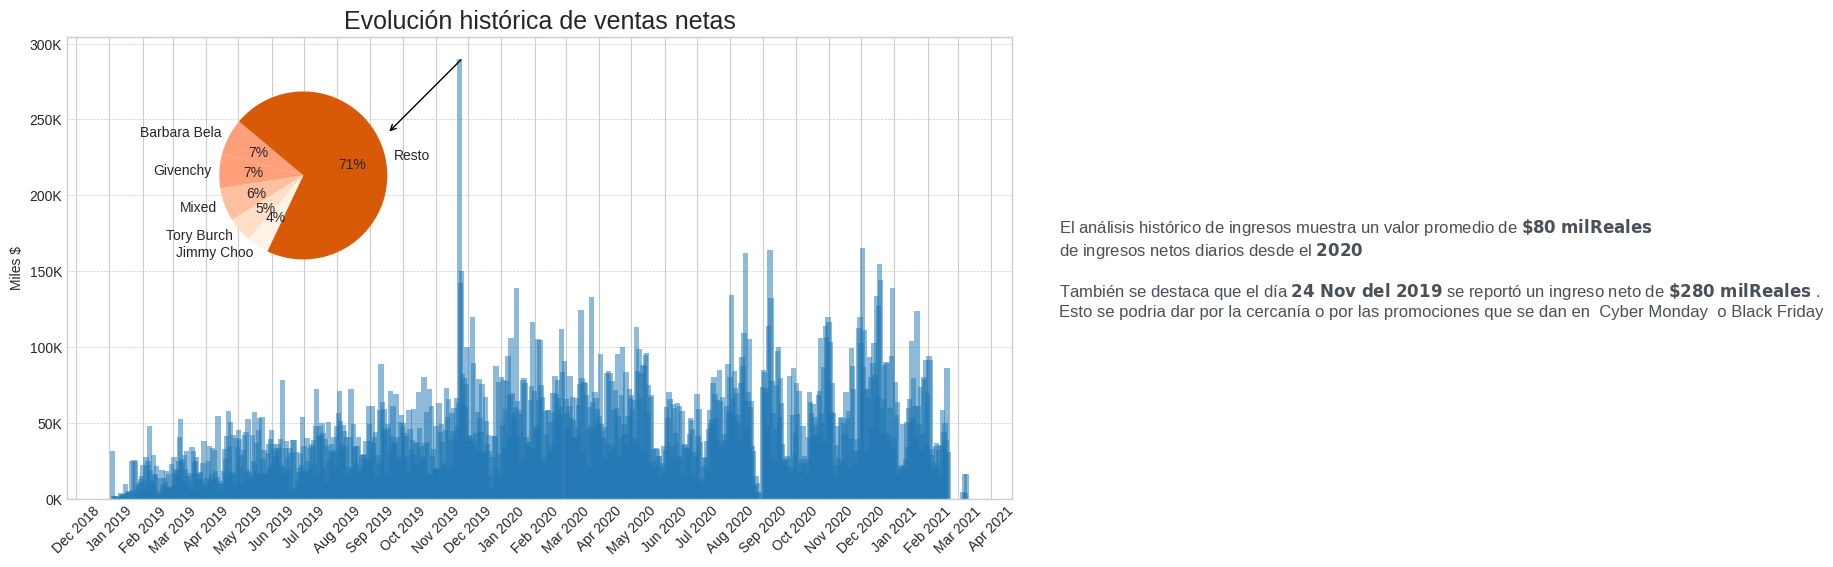

In [ ]:
# Identificamos las mejores marcas y sumamos el resto de las ventas para simplificar el pastel
mejores_marcas = df_marcas_vendidas.head(5)
resto_ventas = df_marcas_vendidas.iloc[5:]['ventas_totales'].sum()

# Creamos un nuevo DataFrame con las primeras 5 marcas y el total de las ventas restantes
df_pastel = pd.concat([mejores_marcas, pd.DataFrame({'marca': ['Resto'], 'ventas_totales': [resto_ventas]})])

# Calculamos los porcentajes de las ventas para cada marca
porcentajes = (df_pastel['ventas_totales'] / df_pastel['ventas_totales'].sum() * 100)

# Definimos una paleta de colores marrones para darle sabor al pastel
colors = ['#FFA07b', '#FFA07A', '#FFC09F', '#FFE0C7', '#FFF2E6', '#D85A09']

# Creamos la figura y los ejes para empezar a dibujar
fig, ax = plt.subplots(figsize=(14, 6))  # Ajustamos las dimensiones del gráfico

# Dibujamos el gráfico de barras para visualizar la evolución histórica de los ingresos netos
ax.bar(df_historico.fecha_compra, df_historico.total_ventas, width=5, alpha=0.5)

# Formateamos el eje x con fechas
ax.xaxis.set_major_locator(mdates.DayLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Cambiamos el eje y para mostrar valores en miles de dólares
formatter = FuncFormatter(lambda x, _: f'{x / 1000:.0f}K')
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel('Miles $')

# Agregamos un título al gráfico para darle un toque profesional
plt.title('Evolución histórica de ventas netas', fontsize=18)

# Rotamos el eje x a 45 grados para mejorar la legibilidad
plt.xticks(rotation=45)

# Ajustamos el espacio a la derecha del gráfico para dejar espacio para nuestro texto
fig.subplots_adjust(right=0.8)

# Agregamos un texto de conclusión para resaltar los hallazgos importantes
conclusion_text = (
    "El análisis histórico de ingresos muestra un valor promedio de $\\bf{\\$80\\ mil Reales}$ \n"
    "de ingresos netos diarios desde el $\\bf{2020}$ \n\n"
    "También se destaca que el día $\\bf{24\\ Nov\\ del\\ 2019}$ se reportó un ingreso neto de $\\bf{\\$280\\ mil Reales}$ .\n"
    "Esto se podria dar por la cercanía o por las promociones que se dan en  Cyber Monday  o Black Friday"
)
ax.text(ax.get_xlim()[1] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05, (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2,
        conclusion_text, fontsize=12, color='#495057', va='center', ha='left')

# Mostramos líneas horizontales en el grid para mejorar la visualización
ax.grid(axis='y', linestyle='--', linewidth=0.5)

# Ahora dibujamos el gráfico de pastel encima del gráfico de barras

pie_ax = ax.inset_axes([0.05, 0.5, 0.4, 0.4])  # Definimos posición y tamaño del gráfico de pastel
pie_ax.pie(porcentajes, labels=df_pastel['marca'], autopct='%1.0f%%', startangle=140, colors=colors)
pie_ax.axis('equal')

# Añadimos una flecha desde el gráfico de pastel
pie_ax.annotate('', xy=(1, 0.5), xytext=(1.9, 1.4), arrowprops=dict(facecolor='blue', arrowstyle='->'))

plt.show()

##**Pregunta 3: ¿Cuáles son los ingresos netos por vendedor por año?**

In [ ]:
crear_conexion()
query = """
    SELECT v.nombre_vendedor,
          strftime('%Y', p.fecha_compra) AS year,
          SUM(ip.valor_total - ip.costo_envio) AS total_year
    FROM pedidos p
    JOIN vendedores v ON p.vendedor_id = v.vendedor_id
    JOIN itens_pedidos ip ON p.pedido_id = ip.pedido_id
    GROUP BY v.nombre_vendedor, strftime('%Y', p.fecha_compra)
"""
# Ejecutar la query y guardar el resultado en un dataframe
df = pd.read_sql_query(query, database)

# Pivotear el dataframe para tener una columna por cada año
df = df.pivot(index='nombre_vendedor', columns='year', values='total_year')

# Rellenar los valores NaN con 0
df.fillna(0, inplace=True)

In [ ]:
df.head()

year,2019,2020,2021
nombre_vendedor,,,
Ana Duarte,2154261.6,5054009.6,547470.4
Daniel Siqueira,2020503.2,5266932.8,419702.4
Millena Pereira,2054682.4,3804385.6,398896.0
Nadia Oliveira,2296986.4,4046902.4,810020.0
Paulo Calanca,3702835.2,3609530.4,455401.6


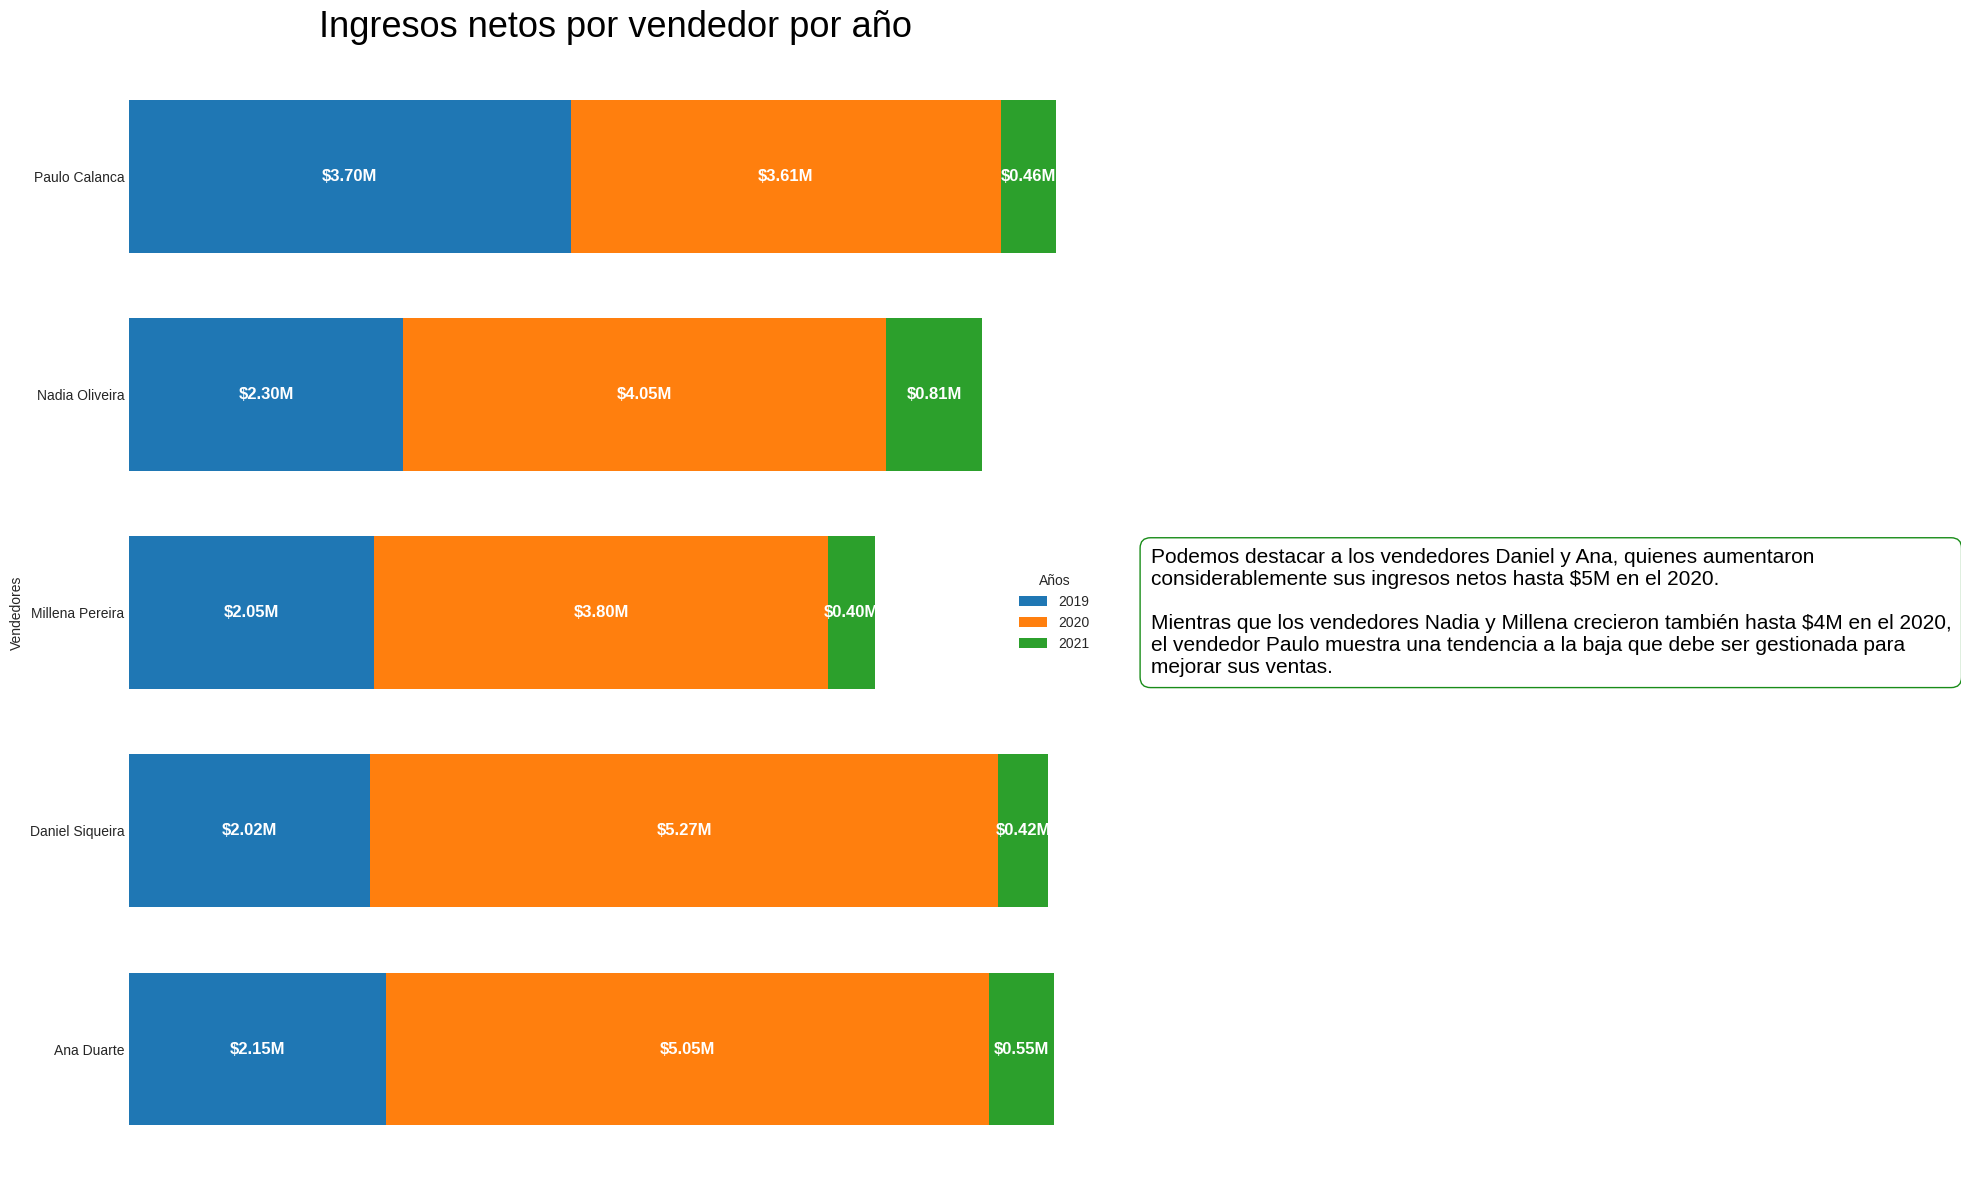

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_stacked_bar(df):
    # Cambiar el índice a un índice de tipo Categorical
    df.index = pd.CategoricalIndex(df.index)

    # Crear el gráfico de barras apiladas con Matplotlib
    ax = df.plot(kind='barh', stacked=True, figsize=(20, 12), width=0.7)
    #ax = df.plot(kind='barh', stacked=True, figsize=(20, 12), width=0.7, bar_spacing=0.2)

    # Configurar el gráfico
    ax.set_title('Ingresos netos por vendedor por año', fontsize=26, color='black', family='sans-serif')
    ax.set_ylabel('Vendedores')
    ax.legend(title='Años')

    # Ajustar las etiquetas del eje Y para que se muestren correctamente
    plt.yticks(rotation=0, ha='right')

    # Eliminar las líneas del gráfico
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Desactivar las líneas de la cuadrícula del eje X
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    # Eliminar las etiquetas del eje X
    ax.set_xticklabels([])

    # Agregar etiquetas de montos de venta neta en millones ($M)
    for i, (index, row) in enumerate(df.iterrows()):
        x_offset = 0
        for j, value in enumerate(row):
            if value != 0:  # Evitar etiquetas para valores cero
                value_in_millions = value / 1_000_000  # Dividir el valor entre 1,000,000 para mostrarlo en millones
                ax.text(x_offset + value / 2, i, f'${value_in_millions:.2f}M', color='white', ha='center', va='center', fontsize=12,fontweight='bold')
            x_offset += value

    # Texto descriptivo del gráfico
    description_text = (
        "Podemos destacar a los vendedores Daniel y Ana, quienes aumentaron\n"
        "considerablemente sus ingresos netos hasta $5M en el 2020.\n"
        "\n"
        "Mientras que los vendedores Nadia y Millena crecieron también hasta $4M en el 2020,\n"
        "el vendedor Paulo muestra una tendencia a la baja que debe ser gestionada para\n"
        "mejorar sus ventas."
    )

    #ax.text(1.05, 0.5, description_text, transform=ax.transAxes, fontsize=15, ha='left', va='center', color='black')
    # Posición para el recuadro del texto descriptivo en el lado derecho del gráfico
    ax.text(1.05, 0.5, description_text, transform=ax.transAxes, fontsize=15, ha='left', va='center', color='black', bbox=dict(facecolor='white', alpha=0.9, edgecolor='green', boxstyle='round,pad=0.5'))


    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

plot_stacked_bar(df)

##**Pregunta 4: ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?**

In [ ]:
crear_conexion()
query = """
SELECT ip.ciudad, SUM(p.total - ip.costo_envio) AS ingresos_netos, SUBSTR(ip.ciudad, 4) AS abbrev_state
FROM pedidos p
INNER JOIN itens_pedidos ip ON p.pedido_id = ip.pedido_id
GROUP BY ip.ciudad, abbrev_state
ORDER BY abbrev_state ASC
LIMIT 70;
"""
# Ejecutar la consulta y cargar los resultados en un DataFrame
df = pd.read_sql_query(query, database)

database.dispose()

In [ ]:
df

,ciudad,ingresos_netos,abbrev_state
0,BR-AC,1128520.0,AC
1,BR-AL,1522016.0,AL
2,BR-AM,1244092.8,AM
3,BR-AP,1475737.6,AP
4,BR-BA,1321893.6,BA
5,BR-CE,1468080.8,CE
6,BR-DF,1327094.4,DF
7,BR-ES,1275874.4,ES
8,BR-GO,1418205.6,GO
9,BR-MA,1453059.2,MA


In [ ]:
br_uf = geobr.read_state()
br_uf.head()

,code_state,abbrev_state,name_state,code_region,name_region,geometry
0,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-63.32721 -7.97672, -62.86662 ..."
1,12.0,AC,Acre,1.0,Norte,"MULTIPOLYGON (((-73.18253 -7.33550, -72.58477 ..."
2,13.0,AM,Amazonas,1.0,Norte,"MULTIPOLYGON (((-67.32609 2.02971, -67.31682 2..."
3,14.0,RR,Roraima,1.0,Norte,"MULTIPOLYGON (((-60.20051 5.26434, -60.19273 5..."
4,15.0,PA,Pará,1.0,Norte,"MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2..."


In [ ]:
br_uf_d = br_uf.merge(df)
br_uf_d = br_uf_d[["geometry", "ingresos_netos"]]
br_uf_d.head()

,geometry,ingresos_netos
0,"MULTIPOLYGON (((-63.32721 -7.97672, -62.86662 ...",1317495.2
1,"MULTIPOLYGON (((-73.18253 -7.33550, -72.58477 ...",1128520.0
2,"MULTIPOLYGON (((-67.32609 2.02971, -67.31682 2...",1244092.8
3,"MULTIPOLYGON (((-60.20051 5.26434, -60.19273 5...",1349770.4
4,"MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2...",1345199.2


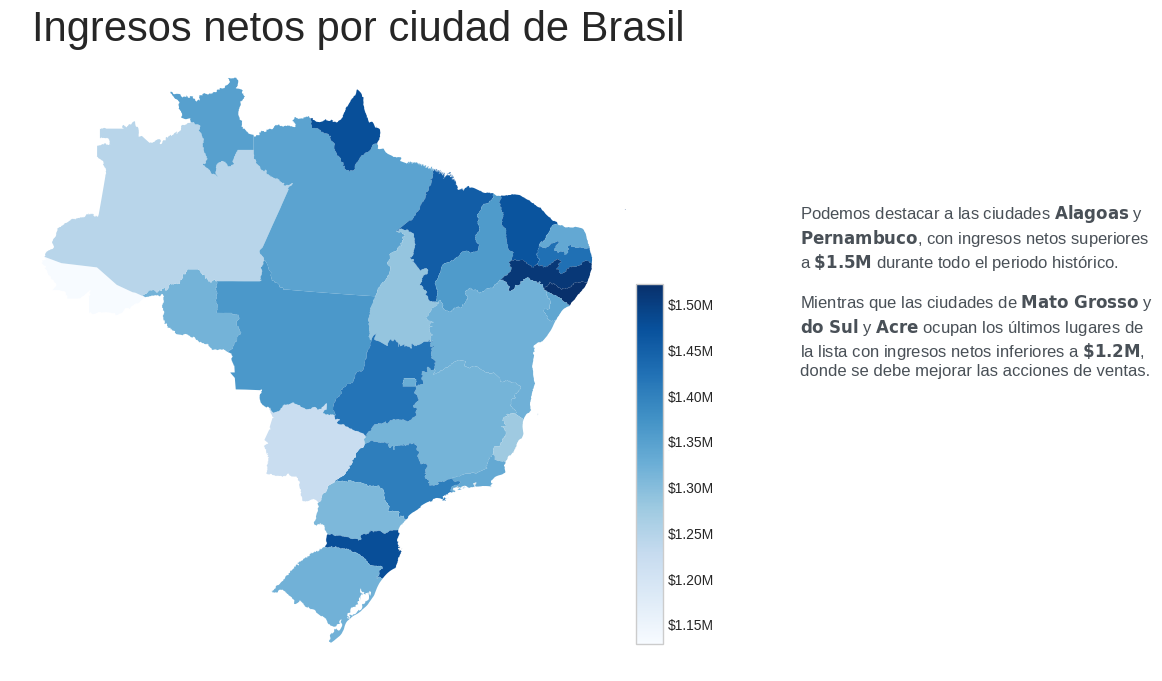

In [ ]:
f, ax = plt.subplots()
plt.title('Ingresos netos por ciudad de Brasil', fontsize=30)
f.set_size_inches(9, 9)
br_uf_d.plot(ax=ax,column="ingresos_netos",cmap="Blues")

# Crea un eje usado para hacer la barra de colores.
cax = f.add_axes(
    [
        0.82,    # posición x (entre 0.0 e 1.0)
        0.18,    # posición y (entre 0.0 e 1.0)
        0.03,    # ancho x
        0.40,    # alto y
    ]
)

sm = plt.cm.ScalarMappable(
    cmap="Blues",  # Utilice el mismo cmap que el mapa.
    norm=plt.Normalize(
        vmin=br_uf_d["ingresos_netos"].min(),  # Valor mínimo
        vmax=br_uf_d["ingresos_netos"].max(),  # Valor máximo
    ),
)
# Pon el eje con la barra de colores en la misma figura que el mapa.
f.colorbar(
    sm, cax=cax,
    format=ticker.FuncFormatter(lambda x, _: f'${x / 1000000:.2f}M')
)

conclusion_text = (
    "Podemos destacar a las ciudades $\\bf{Alagoas}$ y\n"
    "$\\bf{Pernambuco}$, con ingresos netos superiores\n"
    "a $\\bf{\\$1.5M}$ durante todo el periodo histórico.\n"
    " \n"
    "Mientras que las ciudades de $\\bf{Mato\\ Grosso}$ y\n"
    "$\\bf{do\\ Sul}$ y $\\bf{Acre}$ ocupan los últimos lugares de\n"
    "la lista con ingresos netos inferiores a $\\bf{\\$1.2M}$,\n"
    "donde se debe mejorar las acciones de ventas.\n"
)

ax.text(-20,-10,conclusion_text,fontsize=12, color='#495057',va='center')

ax.axis('off')
ax.axis('off')  # Apaga todos los ejes y etiquetas
ax.spines['left'].set_visible(False)  # Oculta el eje izquierdo
ax.spines['right'].set_visible(False)  # Oculta el eje derecho
ax.spines['bottom'].set_visible(False)  # Oculta el eje inferior
ax.spines['top'].set_visible(False)  # Oculta el eje superior

##**Pregunta 5: Top 10 productos más demandados vs Stock de productos**

In [ ]:
crear_conexion()
query_sku = """
SELECT
    p.sku,
    p.producto,
    p.precio,
    SUM(ip.cantidad) AS cantidad_vendida
FROM
    productos p
LEFT JOIN
    itens_pedidos ip ON p.producto_id = ip.producto_id
GROUP BY
    p.sku, p.producto, p.precio
ORDER BY
    SUM(ip.cantidad) DESC
LIMIT 5;
"""
# Ejecutar la consulta SQL y guardar el resultado en un DataFrame
df_sku = pd.read_sql_query(query_sku, database)

In [ ]:
df_sku

,sku,producto,precio,cantidad_vendida
0,302628.0,Saia Midi Cinto,210,549
1,318626.0,Vestido Nude Reta,550,547
2,294463.0,Blusa Manga Estampa,310,536
3,211116.0,Camisa Xadrez Azul,120,511
4,917972.0,Cropped Escritas Pb,280,508


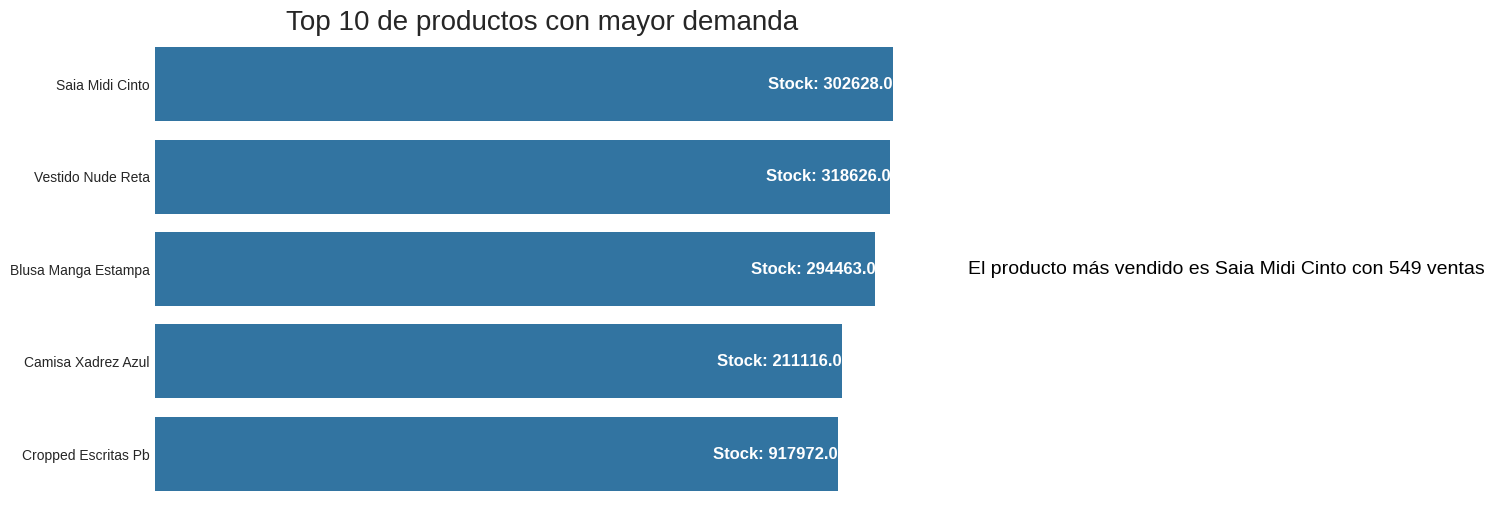

In [ ]:
# Creamos el gráfico de barras horizontales con Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cantidad_vendida', y='producto', data=df_sku, orient='h')

# Quitamos la cuadrícula del fondo
ax.grid(False)

# Quitamos el cuadro delimitador
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Eliminamos etiquetas y ticks del eje y
ax.set_xticks([])
ax.tick_params(axis='x', which='both', length=0)

# Eliminamos el título del eje x
ax.set_xlabel('')

# Eliminamos el título del eje y
ax.set_ylabel('')

# Añadimos título
plt.title('Top 10 de productos con mayor demanda', fontsize=20)

# Añadimos SKU en las barras
for i, row in enumerate(df_sku.itertuples()):
    ax.text(row.cantidad_vendida, i, f"Stock: {row.sku}",
            ha='right', va='center', color='white', fontsize=12, weight='bold')

# Obtenemos límites del eje x y eje y
x_limits = ax.get_xlim()
y_limits = ax.get_ylim()

# Obtenemos el producto más vendido y su información
producto_mas_vendido = df_sku.iloc[0]  # Tomamos la primera fila ya que está ordenada por cantidad vendida
nombre_producto_mas_vendido = producto_mas_vendido['producto']
cantidad_vendida_mas_vendida = producto_mas_vendido['cantidad_vendida']

# Añadir texto adicional debajo de la línea
ax.text(x_limits[1] + (x_limits[1] - x_limits[0]) * 0.05,
        (y_limits[0] + y_limits[1]) / 2,
        f"El producto más vendido es {nombre_producto_mas_vendido} con {cantidad_vendida_mas_vendida} ventas",
        fontsize=14, color='black', va='center', ha='left')

# Mostrar el gráfico
plt.show()


### De acuerdo a la gráfica podemos recomendar que se podria impulsar una campaña de promocion para los productos de  **Cropped Escritas Pb** ya que es uno de los productos mayor vendidos y con mayor stock.